In [1]:
import re
import numpy as np
import nltk as sl
import os
from matplotlib import pyplot as plt
import gensim.models

In [4]:
path = os.getcwd()
print(path)
corpus_path = '/data/corpus/corpus1'

files = os.listdir(path+corpus_path)

/home/desir/Code/PSC-Stats


In [5]:
def get_txt_from_folder(files):
    # Get all .txt files in list of files
    document_list = []
    for k in range(len(files)):
        if files[k][-4:] == ".txt":
            document_list.append(files[k])
    return document_list

In [6]:
class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""
    def __iter__(self): 
        for doc_path in files:
            print('Process doc : ' + doc_path)
            with open(path+corpus_path+"/"+doc_path, "r") as f:
                text = f.read()
            text = re.sub('[^a-zA-Z]+', ' ', text)
            # remove double space
            text = re.sub(' +', ' ', text)

            # lower case
            text = text.lower()

            # remove stop words
            stop_words = sl.corpus.stopwords.words('english')
            text = [w for w in text.split() if not w in stop_words]

            """
            Je ne stem pas car j'utilise un dictionnaire pris sur internet
            # stem words
            stemmer = sl.stem.PorterStemmer()
            result = []
            for w in text:
                if w=='cid' or stemmer.stem(w)=='cid':
                    pass
                result.append(stemmer.stem(w))
            """
            yield text
            
files = get_txt_from_folder(files)

corpus = MyCorpus()

In [7]:
for document in corpus:
    doc = document
    break

Process doc : ireland_national-strategy-for-higher-education-2030-implementation-plan.txt


In [8]:
print(len(doc))

4019


In [35]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

wv_from_bin = gensim.models.Word2Vec.load(path+'/src/gensim/models/w2v')
wv_from_bin = wv_from_bin.wv

In [17]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    new_words = [] # on renvoie une nouvelle liste de mots qui ne contient pas d'abération
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            print(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            new_words.append(w)
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind, new_words

In [12]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        ## Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        ## Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """ 
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    ### SOLUTION BEGIN
    SVD = TruncatedSVD(n_components = k, n_iter = n_iters)   
    SVD.fit(M)
    M_reduced = SVD.transform(M)
    ### SOLUTION END

    print("Done.")
    return M_reduced

In [36]:
from sklearn.cluster import KMeans
import pandas as pd

def plot_embeddings_cluster(M_reduced, word2ind, words):
    '''
    Plot in a 2D-graph the words vectors, highlighting a number n of clusters. We are using the method k-means.

    ## Params:
        M_reduced (numpy matrix of shape (num_corpus_words, dim=2)): co-occurence matrix reduced by reduce_to_k_dim
        word2ind: dictionary mapping each word to its row number in M_reduced 
        words: array of the words vectors we are plotting
    '''
    clf = KMeans(n_clusters= 6) # Modify here the number of clusters
    X = []
    Y= []
    
    for i in range(len(words)):
        k = word2ind[words[i]]
        X.append(M_reduced[k][0])
        Y.append(M_reduced[k][1])
    d= {'X' : X, 'Y' : Y}
    df = pd.DataFrame(data = d)
    clf.fit(df)
    labels = clf.labels_
    colors = ['g.', 'r.', 'b.', 'c.', 'y.', 'm.'] # Modify this array if you use more than 6 clusters (add more colors)
    for i in range(len(df)):
        plt.plot(df.iloc[i,0], df.iloc[i,1], colors[labels[i]], markersize = 10)
        plt.text(df.iloc[i,0], df.iloc[i,1], words[i], fontsize = 9)
    plt.show()


In [40]:
print(doc)
words = doc
print(len(doc))


['national', 'strategy', 'higher', 'education', 'implementation', 'plan', 'june', 'table', 'contents', 'introduction', 'purpose', 'implementation', 'oversight', 'group', 'major', 'actors', 'implementation', 'process', 'proposed', 'cabinet', 'committee', 'higher', 'education', 'key', 'organizations', 'major', 'implementation', 'actions', 'minister', 'department', 'education', 'skills', 'higher', 'education', 'authority', 'qualifications', 'quality', 'authority', 'ireland', 'higher', 'education', 'institutions', 'minister', 'department', 'enterprise', 'jobs', 'innovation', 'research', 'funding', 'agencies', 'implementation', 'cost', 'implementation', 'monitoring', 'appendix', 'table', 'recommendations', 'implementation', 'plan', 'june', 'page', 'introduction', 'purpose', 'purpose', 'plan', 'set', 'detail', 'necessary', 'actions', 'implement', 'recommendations', 'described', 'national', 'strategy', 'higher', 'education', 'ireland', 'show', 'lead', 'responsibility', 'lie', 'amongst', 'vari

In [41]:
from sklearn.decomposition import TruncatedSVD
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind, words = get_matrix_of_vectors(wv_from_bin, words)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting


Shuffling words ...
Putting 4871 words into word2ind and matrix M...
Done.
Running Truncated SVD over 4871 words...
Done.


In [42]:
print(len(words))
print(words)

0
[]


/home/desir/Code/PSC-Stats/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_74510/3300031390.py:23: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  clf.fit(df)


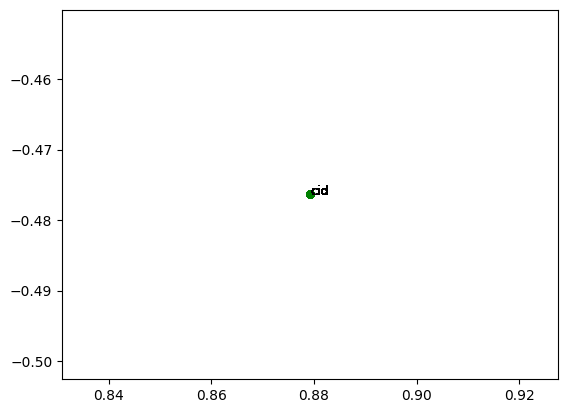

In [28]:
plot_embeddings_cluster(M_reduced_normalized, word2ind, words)

In [22]:
def print_clusters(M_reduced, word2ind, words, n_clust):

    '''
    Printing the elements of each clusters from plot_embeddings_cluster

    ## Params:
        M_reduced (numpy matrix of shape (num_corpus_words, dim=2)): co-occurence matrix reduced by reduce_to_k_dim
        word2ind: dictionary mapping each word to its row number in M_reduced 
        words: array of the words vectors we are plotting
        n_clust (int): number of clusters used in plot_embeddings_cluster
    
    '''
    clf = KMeans(n_clusters= n_clust)
    X = []
    Y= []
    
    for i in range(len(words)):
        k = word2ind[words[i]]
        X.append(M_reduced[k][0])
        Y.append(M_reduced[k][1])
        #plt.scatter(M_reduced[k][0], M_reduced[k][1], color = 'red')
        #plt.text(M_reduced[k][0], M_reduced[k][1], words[i], fontsize = 9)
    d= {'X' : X, 'Y' : Y}
    df = pd.DataFrame(data = d)
    clf.fit(df)
    labels = clf.labels_
    
    L = [ [] for i in range(n_clust)]


    plt.figure(figsize = (20,16))
    for i in range(len(df)):
        plt.subplot(n_clust,1,labels[i]+1)
        plt.plot(df.iloc[i,0], df.iloc[i,1])
        plt.text(df.iloc[i,0], df.iloc[i,1], words[i], fontsize = 9)
        L[labels[i]].append(words[i])
    plt.show()


/home/desir/Code/PSC-Stats/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_74510/1478615343.py:25: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  clf.fit(df)


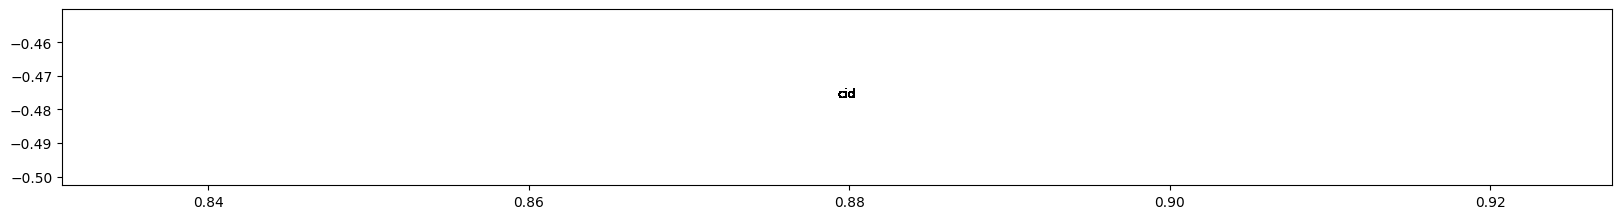

In [23]:
print_clusters(M_reduced_normalized, word2ind, words,6)